 <font size='4'><b>Project 4 - Data cleaning </b></font> 

<a href="https://openclassrooms.com/en/" >Openclassrooms</a>, Data Analyst Course
<br>Project 4 by Michael Orange

<hr>

6 steps will be executed in the below data cleaning process:
* Section 1 - [merge of the 3 datasets](#merge)
* Section 2 - [handle missing data](#missing)
* Section 3 - [remove unwanted observations](#remove)
* Section 4 - [handle duplicated values](#duplicate)
* Section 5 - [data standardization and preparation](#format)
* Section 6 - [export cleaned dataset](#export)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='merge'></a>

<hr>

<h3>Section 1 - merge of the datasets</h3>

Outer merge of the 3 data sets:
- products - products information : id_prod (key), price and category
- customers - customers information : client_id (key), sex, birth
- sales - orders information : session_id = order, date, id_prod (key for products), client_id (key for customers)

In [3]:
customers = pd.read_csv('data/raw/customers.csv')
products = pd.read_csv('data/raw/products.csv')
sales = pd.read_csv('data/raw/transactions.csv')
data = pd.merge(sales, products, how='outer')
data = pd.merge(data, customers, how='outer')

<a id='missing'></a>

<hr>

<h3>Section 2 - handle missing data</h3>

For the merge of 'products' and 'customers' with 'sales', the keys are 'id_prod' and 'client_id'.
- products - if any of the product ID, price or category is not null: the 2 others must be not null. 
- customers - if any of the client ID, sex or birth date is not null: the 2 others must be not null. 
- sales - if any of the order ID (session_id) or order date  is not null: order ID, date and the 2 keys (product ID, client ID) must be not null.

In [8]:
#fonction to verify any anomalies in the merged dataset 'data'

def missing_values():
# check anomalies on products and customers
    anomaly = []
    for j in [customers, products]:
        for z in j.columns:
            for i in j.columns:
                a = data.loc[(~data[z].isnull())&(data[i].isnull())]
                a = list(a[z].unique())
                if a != [] and (z,a,i) not in anomaly:
                    anomaly +=[(z,a, i)]

# check anomalies for orders (session_id)
    for z in (['session_id', 'date']):
        for i in sales.columns:
            a = data.loc[(~data[z].isnull())&(data[i].isnull())]
            a = list(a[z].unique())
            if a != [] and (z,a,i) not in anomaly:
                anomaly +=[(z,a, i)] 

    return anomaly

#listing the anomalies
missing_values()

[('id_prod', ['0_2245'], 'price'), ('id_prod', ['0_2245'], 'categ')]

In [9]:
data.loc[data['id_prod']=='0_2245']

,id_prod,date,session_id,client_id,price,categ,sex,birth
18202,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,NaN,NaN,f,1968.0
18203,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,NaN,NaN,f,1968.0
20708,0_2245,2021-04-17 16:43:16.543156,s_21906,c_7808,NaN,NaN,m,1977.0
27016,0_2245,2021-11-01 14:00:26.535213,s_113219,c_7810,NaN,NaN,m,1978.0
30498,0_2245,2021-09-11 10:52:05.205583,s_88251,c_3468,NaN,NaN,f,1981.0
...,...,...,...,...,...,...,...,...
299794,0_2245,2021-09-19 03:08:45.918021,s_92049,c_4935,NaN,NaN,f,1982.0
311031,0_2245,2021-11-12 09:25:22.905886,s_118458,c_7416,NaN,NaN,m,1933.0
311482,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,NaN,NaN,m,1972.0
324186,0_2245,2021-11-20 20:21:06.505658,s_122593,c_8524,NaN,NaN,f,1982.0


The product 0_2245 has no price and no category:
- there is 103 orders from 100 unique customers. 
- id_prod code starts by '0_' which is the designation for the category 0.

Hypothesis: it might be a missing information. 
<br>Actions: category's values are replaced by '0', and prices by the mean of category 0 products.


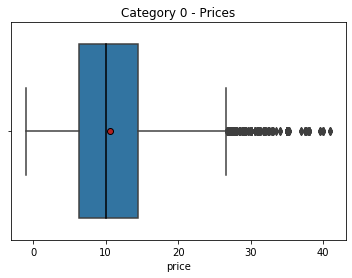

In [11]:
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data.loc[data['categ'] == 0]['price'], showmeans=True, meanprops=meanprops, medianprops=medianprops)
plt.title('Category 0 - Prices')
plt.savefig('data/output_graphics/fig_cleaning1.png', transparent=True)

In [12]:
mean_categ0 = data.loc[data['categ'] == 0]['price'].mean()
median_categ0 = data.loc[data['categ'] == 0]['price'].median()
mode_categ0 = data.loc[data['categ'] == 0]['price'].mode()

'Prices of the category 0: mean of is {}, median is {} and mode is {}'.format(median_categ0, mean_categ0, mode_categ0)

'Prices of the category 0: mean of is 9.99, median is 10.635960656928932 and mode is 0    4.99\ndtype: float64'

Mode is too low to be considered, both median and mean could be used. Due to the number of outliers, **a median substitution is applied**.

In [13]:
data.loc[data['id_prod'] == '0_2245', 'categ'] = 0
data.loc[data['id_prod'] == '0_2245', 'price'] = round(median_categ0, 2)

<a id='remove'></a>

<hr>

<h3>Section 3 - Remove unwanted observations</h3>

There is 200 transactions with a price under 0 from the customers ct_1 and ct_2:
- client_id are 'ct_' instead of the standardized names 'c_',  there is an additional 't' (like test).
- there is a flag 'test_' in the date description for these transactions. 
- products are 'T-0' instead of the '0_', '1_' or '2_'. 
- sessions are flagged 's_0'.

Hypothesis: ct_1, ct_2, T_0 and s_0 are test accounts, products and sessions. 
<br>Actions: ct_1, ct_2, T_0 and s_0 will be removed from the dataset.

In [8]:
data.loc[data['price'] < 0]

,id_prod,date,session_id,client_id,price,categ,sex,birth
336768,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,-1.0,0.0,m,2001.0
336769,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,-1.0,0.0,m,2001.0
336770,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,-1.0,0.0,m,2001.0
336771,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,-1.0,0.0,m,2001.0
336772,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1,-1.0,0.0,m,2001.0
...,...,...,...,...,...,...,...,...
336963,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_0,-1.0,0.0,f,2001.0
336964,T_0,test_2021-03-01 02:30:02.237438,s_0,ct_0,-1.0,0.0,f,2001.0
336965,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0,-1.0,0.0,f,2001.0
336966,T_0,test_2021-03-01 02:30:02.237445,s_0,ct_0,-1.0,0.0,f,2001.0


In [9]:
data.loc[data['price'] < 0].client_id.unique(), data.loc[data['price'] < 0].id_prod.unique(), data.loc[data['price'] < 0].session_id.unique(), \
data.loc[data['price'] < 0].birth.unique()

(array(['ct_1', 'ct_0'], dtype=object),
 array(['T_0'], dtype=object),
 array(['s_0'], dtype=object),
 array([2001.]))

In [10]:
#remove transactions from customers ct_1 and ct_0
data = data.loc[~data['client_id'].isin(['ct_1', 'ct_0'])].copy()

#verify if there is no remaining 'T_0' and 's_0' 
data.loc[ (data['session_id'] == 's_0') |  (data['id_prod'] == 'T_0')]

,id_prod,date,session_id,client_id,price,categ,sex,birth


<a id='duplicate'></a>

<a id='format'></a>

<hr>

<h3>Section 4 - handle duplicated values </h3>

Value is considered duplicated if: 
- a product ID has more than 1 price or more than 1 category.
- a client ID has more than 1 birth date or 1 gender. 
- an order (session_id) has more than 1 customer ID.

In [11]:
def duplicated_values(): 
    duplicated = []
    # customers
    cust = data.pivot_table(index= ['client_id'], values=['birth', 'sex'], aggfunc='nunique')
    if cust.loc[(cust['sex'] != 1) | (cust['birth'] != 1)].empty is False:
        duplicated = list(cust.client_id.index.unique())
    
    #products
    prod = data.pivot_table(index= ['id_prod'], values=['price', 'categ'], aggfunc='nunique')
    if prod.loc[(prod['price'] != 1) | (prod['categ'] != 1)].empty is False:
        duplicated += list(prod.id_prod.index.unique())

    #products
    order = data.pivot_table(index= ['session_id'], values=['client_id'], aggfunc='nunique')
    if order.loc[(order['client_id'] != 1)].empty is False:
        duplicated += list(order.session_id.index.unique())
    
    if duplicated == []:
        print('There is no duplicated values')
    else: 
        return 'Duplicated values: {}'.format(duplicated)

duplicated_values()

There is no duplicated values


<hr>

<h3>Section 5 - data standardization and preparation </h3>

In [12]:
# convert 'date' into date format
data['date'] =pd.to_datetime(data['date'])

In [13]:
# In order to maintain constant ages per customer (simplification) we will calculate ages based on the fixed year 2022
currentYear = 2022
data['client_age'] = currentYear - data['birth']

In [14]:
# ages by bins
grouped_ages = [17]
while True:
    i = 6
    grouped_ages.append(grouped_ages[-1]+i)
    if (grouped_ages[-1]) >= data.client_age.max():
        break
data['age_bins'] = pd.cut(x=data['client_age'], bins=grouped_ages)

In [18]:
#subset : data_customers 
data_customers = data.pivot_table(index='client_id', values=['sex', 'client_age', 'age_bins'], aggfunc='first')

data_customers['sales'] = data.groupby('client_id')['price'].sum()
data_customers['nb_orders'] = data.groupby('client_id')['session_id'].nunique()
data_customers['nb_prod'] = data.groupby('client_id')['id_prod'].count()

#date
data_customers['date_first_order'] = data.groupby('client_id')['date'].min()
data_customers['month_first_order'] = data_customers['date_first_order'].dt.to_period('M')
last_date = data['date'].max()
data_customers['active_days'] = last_date - data_customers['date_first_order']
data_customers['active_month'] = [data_customers['active_days'][k].days /30 for k in range(len(data_customers))]

data_customers['avg_order_value'] = data_customers['sales']/data_customers['nb_orders'] 
data_customers['freq_orders'] = data_customers['nb_orders'] / data_customers['active_month']
data_customers['nb_prod_order'] = data_customers['nb_prod']/data_customers['nb_orders']

data_customers.reset_index(inplace=True)
data_customers['client_age'] = data_customers.client_age.astype('Int64')
data_customers

,client_id,age_bins,client_age,sex,sales,nb_orders,nb_prod,date_first_order,month_first_order,active_days,active_month,avg_order_value,freq_orders,nb_prod_order
0,c_1,"(65, 71]",67,m,300.65,15,20,2021-06-11 21:02:39.382765,2021-06,262 days 02:57:18.657707,8.733333,20.043333,1.717557,1.333333
1,c_10,"(65, 71]",66,m,586.18,16,28,2021-03-21 02:50:16.551727,2021-03,344 days 21:09:41.488745,11.466667,36.636250,1.395349,1.750000
2,c_100,"(29, 35]",30,m,222.87,3,6,2021-04-20 05:26:43.133053,2021-04,314 days 18:33:14.907419,10.466667,74.290000,0.286624,2.000000
3,c_1000,"(53, 59]",56,f,980.02,42,56,2021-03-13 13:34:14.618755,2021-03,352 days 10:25:43.421717,11.733333,23.333810,3.579545,1.333333
4,c_1001,"(35, 41]",40,m,1102.45,24,58,2021-03-07 13:01:15.964197,2021-03,358 days 10:58:42.076275,11.933333,45.935417,2.011173,2.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,c_995,"(65, 71]",67,m,119.08,5,8,2021-04-08 02:50:33.499557,2021-04,326 days 21:09:24.540915,10.866667,23.816000,0.460123,1.600000
8617,c_996,"(47, 53]",52,f,739.60,36,42,2021-03-01 15:06:18.594244,2021-03,364 days 08:53:39.446228,12.133333,20.544444,2.967033,1.166667
8618,c_997,"(23, 29]",28,f,572.89,10,23,2021-04-30 19:41:32.340325,2021-04,304 days 04:18:25.700147,10.133333,57.289000,0.986842,2.300000
8619,c_998,"(17, 23]",21,m,1527.69,13,28,2021-03-18 01:32:33.677785,2021-03,347 days 22:27:24.362687,11.566667,117.514615,1.123919,2.153846


In [21]:
#subset : data_prod
data_prod = data.pivot_table(index='id_prod', values=['categ', 'price'], aggfunc='first')

data_prod['nb_sold'] = data.groupby('id_prod')['session_id'].count()
data_prod['sales'] = data_prod['nb_sold']*data_prod['price']

data_prod.reset_index(inplace=True)
data_prod["categ"]=  data_prod.categ.astype('Int64')
data_prod

,id_prod,categ,price,nb_sold,sales
0,0_0,0,3.75,611,2291.25
1,0_1,0,10.99,249,2736.51
2,0_10,0,17.95,12,215.40
3,0_100,0,20.60,2,41.20
4,0_1000,0,6.84,222,1518.48
...,...,...,...,...,...
3282,2_95,2,98.99,3,296.97
3283,2_96,2,47.91,281,13462.71
3284,2_97,2,160.99,5,804.95
3285,2_98,2,149.74,1,149.74


In [23]:
#subset : data_transac
data_transac = data.loc[~data['session_id'].isnull()].copy()
data_transac['client_age'] = data_transac.client_age.astype('Int64')
data_transac['categ'] = data_transac.categ.astype('Int64')
data_transac

,id_prod,date,session_id,client_id,price,categ,sex,birth,client_age,age_bins
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977.0,45,"(41, 47]"
1,0_1085,2021-09-29 11:14:59.793823,s_97382,c_4450,3.99,0,f,1977.0,45,"(41, 47]"
2,0_1453,2021-08-27 19:50:46.796939,s_81509,c_4450,7.99,0,f,1977.0,45,"(41, 47]"
3,0_1405,2021-08-27 20:07:25.878440,s_81509,c_4450,4.99,0,f,1977.0,45,"(41, 47]"
4,0_1392,2021-12-28 11:45:04.072281,s_141302,c_4450,6.30,0,f,1977.0,45,"(41, 47]"
...,...,...,...,...,...,...,...,...,...,...
337011,1_607,2021-09-25 07:26:00.224331,s_95185,c_4786,26.99,1,f,1967.0,55,"(53, 59]"
337012,1_673,2021-06-01 00:49:49.781631,s_42350,c_2793,12.99,1,m,1933.0,89,"(83, 89]"
337013,0_2075,2021-10-09 09:03:48.268536,s_102200,c_2793,8.99,0,m,1933.0,89,"(83, 89]"
337014,0_1692,2021-09-15 19:42:08.596375,s_90430,c_4478,13.36,0,f,1970.0,52,"(47, 53]"


In [25]:
#subset : data_orders
data_orders = data[~data['session_id'].isnull()].pivot_table(index='session_id', values=['client_id', 'client_age', 'sex', 'birth', 'age_bins', 'date'], aggfunc='first')

data_orders['order_month'] = data_orders.date.dt.month
data_orders['order_value'] = data.groupby('session_id')['price'].sum()

data_orders.reset_index(inplace=True)
data_orders['client_age'] = data_orders.client_age.astype('Int64')
data_customers['age_bins'] = pd.arrays.IntervalArray(data_customers['age_bins'], dtype='interval[int64]')
data_orders

,session_id,age_bins,birth,client_age,client_id,date,sex,order_month,order_value
0,s_1,"(53, 59]",1967.0,55,c_329,2021-03-01 00:01:07.843138,f,3,11.99
1,s_10,"(47, 53]",1970.0,52,c_2218,2021-03-01 00:10:33.163037,f,3,26.99
2,s_100,"(41, 47]",1978.0,44,c_3854,2021-03-01 04:12:43.572994,f,3,33.72
3,s_1000,"(29, 35]",1989.0,33,c_1014,2021-03-03 02:49:03.169115,m,3,39.22
4,s_10000,"(29, 35]",1989.0,33,c_476,2021-03-22 18:15:03.831240,f,3,41.49
...,...,...,...,...,...,...,...,...,...
169189,s_99994,"(35, 41]",1983.0,39,c_7685,2021-10-04 18:56:23.112236,m,10,28.92
169190,s_99995,"(59, 65]",1960.0,62,c_4170,2021-10-04 18:35:32.201073,f,10,19.84
169191,s_99996,"(47, 53]",1974.0,48,c_4900,2021-10-04 18:39:10.485474,f,10,56.27
169192,s_99997,"(41, 47]",1979.0,43,c_3521,2021-10-04 18:45:38.003516,f,10,6.99


<a id='export'></a>

<hr>

<h3>Section 6 - export cleaned datasets </h3>

In [16]:
data_master = data
#exporting data_master - all
data.to_csv(r'data/output/data_master.csv', index = False)

In [20]:
#exporting data customer
data_customers.to_csv('data/output/data_customers.csv', index = False)

In [22]:
#exporting data prod
data_prod.to_csv('data/output/data_prod.csv', index = False)

In [24]:
#exporting data_transac
data_transac.to_csv('data/output/data_transac.csv', index=False)

In [26]:
#exporting data_orders
data_orders.to_csv('data/output/data_orders.csv', index = False)